## Amazon Review Data : Data Exploration

### Setup spark

In [1]:
# Import libraries
import os, pickle, glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from pyspark.sql import SparkSession, SQLContext, DataFrame
from pyspark.sql.types import StringType
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.stat import Summarizer
from pyspark.ml.feature import Word2Vec, Tokenizer, StringIndexer, OneHotEncoder, PCA, VectorAssembler

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Matplotlib created a temporary cache directory at /tmp/matplotlib-ypq4dq7e because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "128g") \
	.config("spark.executor.memory", "64g") \
    .config('spark.executor.instances', 64) \
	.appName("Amazon Reviews") \
	.getOrCreate()


In [3]:
sqlContext = SQLContext(sc)

/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Code to check data size

In [4]:
def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)
    return total_size

folder_path = "../clin6/amazon_data"
folder_size_bytes = get_folder_size(folder_path)
folder_size_kb = folder_size_bytes / 1024
folder_size_mb = folder_size_kb / 1024
folder_size_gb = folder_size_mb / 1024

print("Folder size:", folder_size_bytes, "bytes")
print("Folder size:", folder_size_kb, "KB")
print("Folder size:", folder_size_mb, "MB")
print("Folder size:", folder_size_gb, "GB")

Folder size: 54412794661 bytes
Folder size: 53137494.78613281 KB
Folder size: 51892.084752082825 MB
Folder size: 50.67586401570588 GB


## Read Data

### Get files

In [8]:
#######################################################################################
###################### change path to: "../clin6/amazon_data" #########################
#######################################################################################
path = "../clin6/amazon_data"

In [9]:
def read(path):
    """
    Method that loads data file as df
    Takes in 1 parameter: path
    """
    return sc.read.csv(path, sep = "\t", header = True, inferSchema = True)

def get_path(file):
    """
    Method to create path
    Takes in 1 parameter: file name
    """
    return "../clin6/amazon_data/%s" % file

In [10]:
dir = os.listdir(path)
files = [f for f in dir if os.path.isfile(os.path.join(path, f))]

# Data Preprocessing
* Finish major preprocessing, this includes scaling and/or transforming your data, imputing your data, encoding your data, feature expansion, Feature expansion (example is taking features and generating new features by transforming via polynomial, log multiplication of features).

In [11]:
product_category_column = 'product_category'
review_body_column = 'review_body'
review_date_column = 'review_date'
title_column = 'product_title'
category_column = 'product_category'
product_parent_column = 'product_parent'
review_body_column = 'review_body'
verified_purchase_column = 'verified_purchase'

product_category_col = F.col(product_category_column)
review_body_col = F.col(review_body_column)
review_date_col = F.col(review_date_column)
title_col = F.col(title_column)
category_col = F.col(category_column)
product_parent_col = F.col(product_parent_column)
review_body_col = F.col(review_body_column)
verified_purchase_col = F.col(verified_purchase_column)

## Load Data & Take care of missing categories

In [12]:
def get_imputed_df(files, category = True):
    """
    Method that combines files into 1 big df
    Takes in 1 parameter: list of file names
    """
    df = None
    n = len(files)
    categories = {}
    for i in range(n):
        data = read(get_path(files[i]))
        
        # Fill in null categories
        if category:
            cat = files[i][18:-10]
            categories[cat] = i
            data = data.withColumn(product_category_column,
                                   product_category_col).fillna(cat)
        
        if df is None:
            df = data
        else:
            df = df.union(data)
    return df, categories

## Get df & Remove Columns

In [13]:
df, categories = get_imputed_df(files)
df = df.drop('marketplace', 'vine')#.cache()

In [14]:
sqlContext.registerDataFrameAsTable(df, "df")

In [15]:
columns = df.columns
num_cols = len(columns)

## Filter out rows with missing body and date and verified purchase

In [16]:
df = df.filter(review_body_col.isNotNull() & review_date_col.isNotNull())
df = df.filter(verified_purchase_col == True)

In [17]:
df.show(1)

+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+---------------+--------------------+-----------+
|customer_id|    review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|verified_purchase|review_headline|         review_body|review_date|
+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+---------------+--------------------+-----------+
|   36075342|RAB23OVFNCXZQ|B00LPRXQ4Y|     339193102|17" 2003-2006 For...|      Automotive|          1|            0|          0|                Y|As it was used,|As it was used, t...| 2015-08-31|
+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+---------------+--------------------+-----------+
only showing to

In [15]:
# Select the review_date column
review_date_col = F.col('review_date')

# Find the minimum and maximum dates
min_max_dates = df.agg(F.min(review_date_col).alias('min_date'), 
                       F.max(review_date_col).alias('max_date'))

min_max_dates.show()

+----------+----------+
|  min_date|  max_date|
+----------+----------+
|1995-11-09|2015-08-31|
+----------+----------+



## Filter out old data

In [18]:
# Data before 2010 is more irrelevent to forcaste future trends. 
df = df.filter(F.year(review_date_col) >= 2010)
df.show(1)

+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+---------------+--------------------+-----------+
|customer_id|    review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|verified_purchase|review_headline|         review_body|review_date|
+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+---------------+--------------------+-----------+
|   36075342|RAB23OVFNCXZQ|B00LPRXQ4Y|     339193102|17" 2003-2006 For...|      Automotive|          1|            0|          0|                Y|As it was used,|As it was used, t...| 2015-08-31|
+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+---------------+--------------------+-----------+
only showing to

## Check other missing values

In [19]:
for i in range(num_cols):
    missing = df.filter(df[columns[i]].isNull()).count()
    print("'%s' column has %d missing values" % (columns[i], missing))

'customer_id' column has 0 missing values
'review_id' column has 0 missing values
'product_id' column has 0 missing values
'product_parent' column has 0 missing values
'product_title' column has 0 missing values
'product_category' column has 0 missing values
'star_rating' column has 0 missing values
'helpful_votes' column has 0 missing values
'total_votes' column has 0 missing values
'verified_purchase' column has 0 missing values
'review_headline' column has 0 missing values
'review_body' column has 0 missing values
'review_date' column has 0 missing values


* No more missing values

## Extract month and year

In [20]:
month_column = 'month'
year_column = 'year'

In [21]:
df = df.withColumn(month_column, F.month(review_date_col)).withColumn(year_column, F.year(review_date_col))
df.show(1)

+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+---------------+--------------------+-----------+-----+----+
|customer_id|    review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|verified_purchase|review_headline|         review_body|review_date|month|year|
+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+---------------+--------------------+-----------+-----+----+
|   36075342|RAB23OVFNCXZQ|B00LPRXQ4Y|     339193102|17" 2003-2006 For...|      Automotive|          1|            0|          0|                Y|As it was used,|As it was used, t...| 2015-08-31|    8|2015|
+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+---------------+-----

## Add Sub-category Column

In [33]:
subcategory_mapping = {
    'Major_Appliances': 'Home Essentials',
    'Kitchen': 'Home Essentials',
    'Home_Improvement': 'Home Essentials',
    'Tools': 'Home Essentials',
    'Home': 'Home Essentials',
    'Furniture': 'Home Essentials',
    'Office_Products':'Home Essentials',
    
    'Outdoors': 'Outdoor Living',
    'Home_Entertainment': 'Outdoor Living',
    'Lawn_and_Garden': 'Outdoor Living',
    
    'Video': 'Media',
    'Video_DVD': 'Media',
    'Music': 'Media',
    'Books': 'Media',
    'Video_Games': 'Media',
    'Software': 'Media',
    
    'Digital_Music_Purchase': 'Digital Media',
    'Digital_Video_Download': 'Digital Media',
    'Digital_Ebook_Purchase': 'Digital Media',
    'Digital_Video_Games': 'Digital Media',
    'Digital_Software':'Digital Media',

    'Mobile_Apps': 'Electronics',
    'Wireless': 'Electronics',
    'PC': 'Electronics',
    'Electronics': 'Electronics',
    'Mobile_Electronics': 'Electronics',
    'Camera': 'Electronics',
    
    'Shoes': 'Apparel and Accessories',
    'Watches': 'Apparel and Accessories',
    'Luggage': 'Apparel and Accessories',
    'Apparel': 'Apparel and Accessories',
    
    'Health_Personal_Care': 'Personal Care',
    'Beauty': 'Personal Care',
    'Personal_Care_Appliances': 'Personal Care',
    
    'Sports': 'Entertainment and Leisure',
    'Musical_Instruments': 'Entertainment and Leisure',
    'Toys': 'Entertainment and Leisure',
    'Gift_Card': 'Entertainment and Leisure',
    
    'Baby': 'Family and Living',
    'Automotive': 'Family and Living',
    'Grocery': 'Family and Living',
    'Pet_Products': 'Family and Living',
}

In [22]:
'''
from pyspark.sql.functions import year, month, col, date_format,count

# Assuming your DataFrame is called 'df'

# Filter the DataFrame for rows where the month is December and the year is 2014
df_dec_2014 = df.filter((year(df['review_date']) == 2014) & (month(df['review_date']) == 12))

# Count the number of rows
count_dec_2014 = df_dec_2014.count()

print("Count of review_date in December 2014:", count_dec_2014)
'''

'\nfrom pyspark.sql.functions import year, month, col, date_format,count\n\n# Assuming your DataFrame is called \'df\'\n\n# Filter the DataFrame for rows where the month is December and the year is 2014\ndf_dec_2014 = df.filter((year(df[\'review_date\']) == 2014) & (month(df[\'review_date\']) == 12))\n\n# Count the number of rows\ncount_dec_2014 = df_dec_2014.count()\n\nprint("Count of review_date in December 2014:", count_dec_2014)\n'

## Encode Categorical Columns

### Match category to numbers

In [23]:
category_num_col = 'product_category_num'

In [24]:
def translate(dic): 
    return F.udf(lambda x: dic.get(x), StringType()) 

df = df.withColumn('product_category', translate(categories)(category_col))

### Change title into vectors

In [24]:
titleArray_column = 'titleArray'
titleVector_column = 'titleVector'

In [25]:
df = df.withColumn(titleArray_column, F.split(F.lower(F.col(title_column)), ' '))

In [ ]:
word2vec = Word2Vec(inputCol = titleArray_column, outputCol = titleVector_column,
                    minCount = 100, vectorSize = 16, numPartitions = 4)
model = word2vec.fit(df)
df = model.transform(df)

### Change text into vectors

In [ ]:
reviewArray_column = 'reviewArray'
reviewVector_column = 'reviewVector'

In [ ]:
df = df.withColumn(reviewArray_column, F.split(F.lower(F.col(review_body_column)), ' '))

In [ ]:
word2vec = Word2Vec(inputCol = reviewArray_column, outputCol = reviewVector_column,
                    minCount = 100, vectorSize = 16, numPartitions = 4)
model = word2vec.fit(df)
df = model.transform(df)

In [ ]:
# remove stop words
# get the most repeated words 

In [ ]:
df.first(1)

## Dataset Splitting
* Use last year as test and the rest as train

In [25]:
train = df.filter((F.year(review_date_col) >= 2010) & (F.year(review_date_col) < 2015))
test = df.filter(F.year(review_date_col) == 2015)

In [27]:
print(train.count())
print(test.count())

56637783
27498612


## Count Product Reviews Per Day
* Group by unique product identifier and day to get reviews per day for each product

In [28]:
grouped_df = df.groupby(review_date_col, product_parent_col).count()

# Visualizations Before Modeling
## Get training data

In [29]:
train_df = train.select(review_date_col, product_category_col)\
                .withColumn("review_date", F.date_format(review_date_col, "yyyy-MM"))\
                .na.drop()

train_df.show(10)

+-----------+----------------+
|review_date|product_category|
+-----------+----------------+
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
+-----------+----------------+
only showing top 10 rows



## Get distinct categories

In [30]:
distinct_product_category_num = train_df.select("product_category").distinct()
distinct_product_category_num.count()

42

## Group by `year` and `month` then count

In [31]:
train_df = train_df.withColumn("year", F.year("review_date"))\
                   .withColumn("month", F.month("review_date"))

## Map to subcategories

In [34]:
broadcast_mapping = sc.sparkContext.broadcast(subcategory_mapping)

def get_subcategory(product_category):
    return broadcast_mapping.value.get(product_category, 'unknown')

subcategory_udf = F.udf(get_subcategory, StringType())

train_df = train_df.withColumn('subcategory', subcategory_udf(product_category_col))

## Get counts per month

In [35]:
count_per_month = train_df.groupBy("year", "month", "subcategory").agg(F.count("*").alias("count"))
df_pd = count_per_month.toPandas()

## Plot Trends
### Set plot styles

In [36]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("tab10")

### Plot all sub-category trends

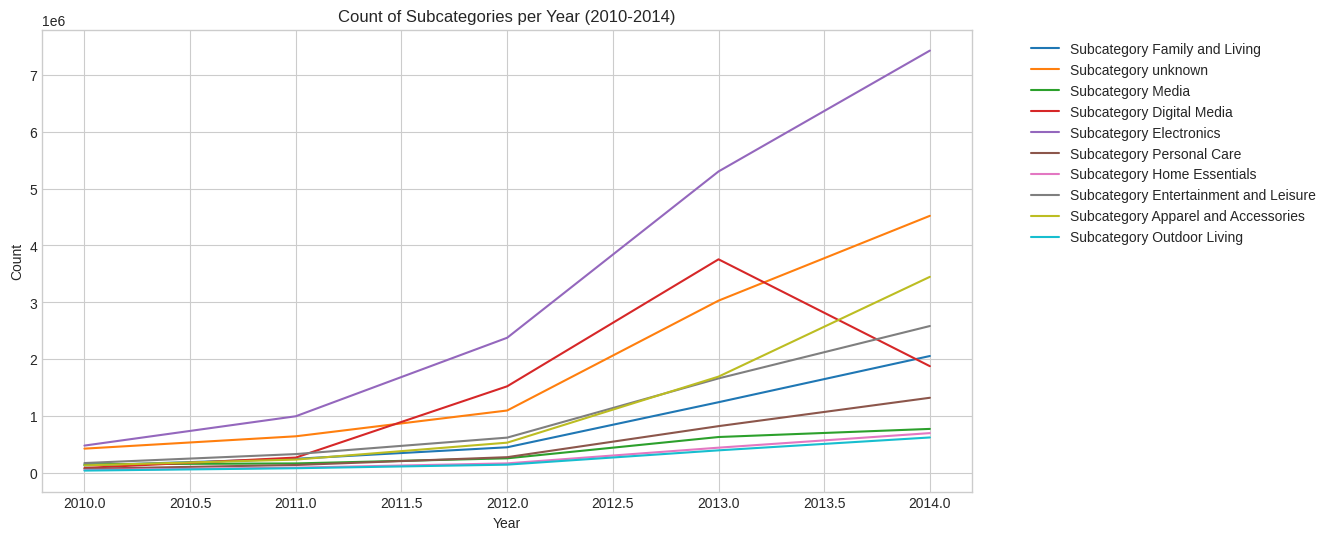

In [37]:
plt.figure(figsize = (12, 6))

for subcategory in df_pd['subcategory'].unique():
    df_subcat = df_pd[df_pd['subcategory'] == subcategory]
    df_subcat = df_subcat.sort_values(by='year')
    df_subcat = df_subcat.groupby('year')['count'].sum().reset_index()
    plt.plot(df_subcat['year'], df_subcat['count'], label = f'Subcategory {subcategory}')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Subcategories per Year (2010-2014)')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()

### Plot single sub-category trend

In [38]:
def plot_category(category):
    '''
    Method to plot single category
    Takes in one string parameter: category
    '''
    plt.figure(figsize = (12, 6))
    df = df_pd[df_pd['subcategory'] == category]
    
    df_grouped = df.groupby('year')['count'].sum().reset_index()
    df_grouped = df_grouped.sort_values(by='year')
    plt.figure(figsize=(12, 6))
    plt.plot(df_grouped['year'], df_grouped['count'], label = 'Subcategory Media')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Count of %s Subcategory per Year' % category)
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    plt.show()

In [39]:
subcategory_list = list(set(subcategory_mapping.values()))
subcategory_list

['Home Essentials',
 'Family and Living',
 'Outdoor Living',
 'Electronics',
 'Media',
 'Entertainment and Leisure',
 'Digital Media',
 'Apparel and Accessories',
 'Personal Care']

<Figure size 1200x600 with 0 Axes>

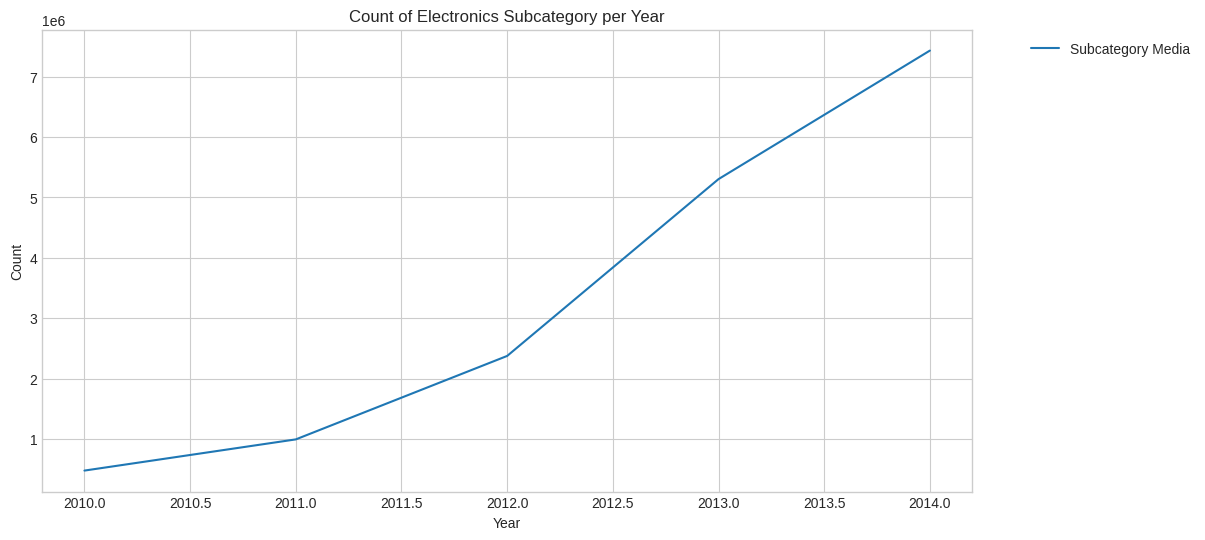

In [40]:
##################### SET CATEGORY ###########################
subcategory = 'Electronics'

plot_category(subcategory)

### Plot category trends in one sub-category

In [41]:
count_per_month_ = train_df.groupBy("year", "month", "subcategory", "product_category").agg(F.count("*").alias("count"))
df_pd_ = count_per_month_.toPandas()
df_pd_.head()

,year,month,subcategory,product_category,count
0,2014,12,Family and Living,Automotive,137851
1,2014,11,Family and Living,Automotive,108319
2,2014,10,Family and Living,Automotive,104014
3,2014,9,Family and Living,Automotive,101488
4,2014,8,Family and Living,Automotive,108145


In [42]:
def plot_categories(subcategory):
    '''
    Plots category trends in one category
    Takes in one string parameter: subcategory
    '''
    df_subcat = df_pd_[df_pd_['subcategory'] == subcategory]
    
    plt.figure(figsize = (12, 6))
    
    for product_category in df_subcat['product_category'].unique():
        df_product_cat = df_subcat[df_subcat['product_category'] == product_category]
        df_product_cat = df_product_cat.sort_values(by='year')
        df_product_cat = df_product_cat.groupby('year')['count'].sum().reset_index()
        plt.plot(df_product_cat['year'], df_product_cat['count'], label=f'Category {product_category}')
        
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Count of Electronics Categories per Year (2010-2014)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

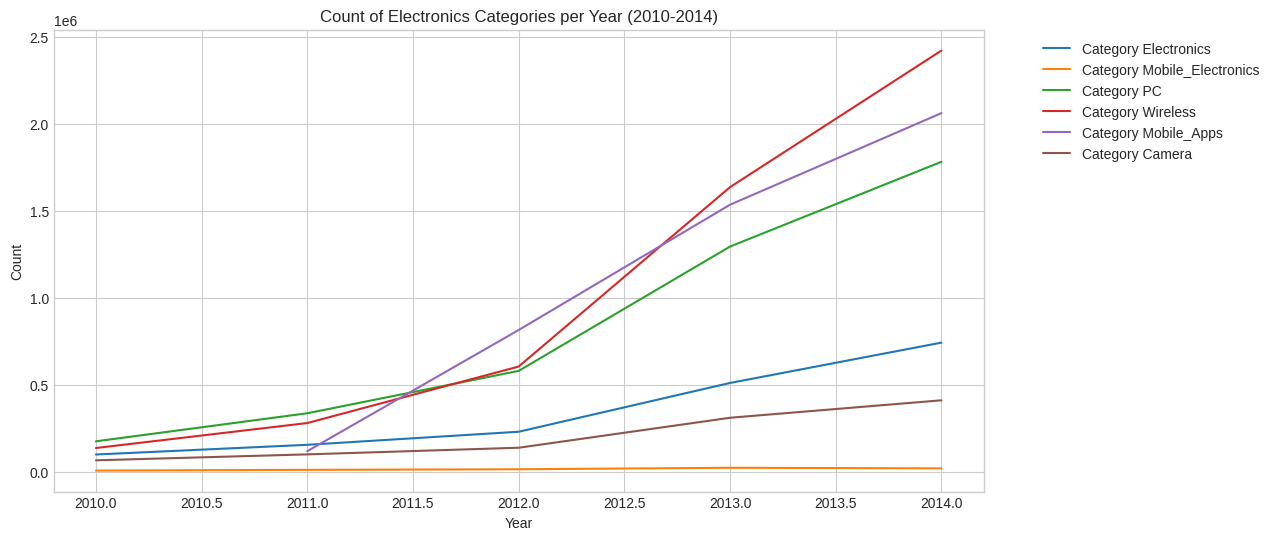

In [43]:
##################### SET SUBCATEGORY ###########################
subcategory = 'Electronics'

plot_categories(subcategory)

### Plot Seasonal Decomposition

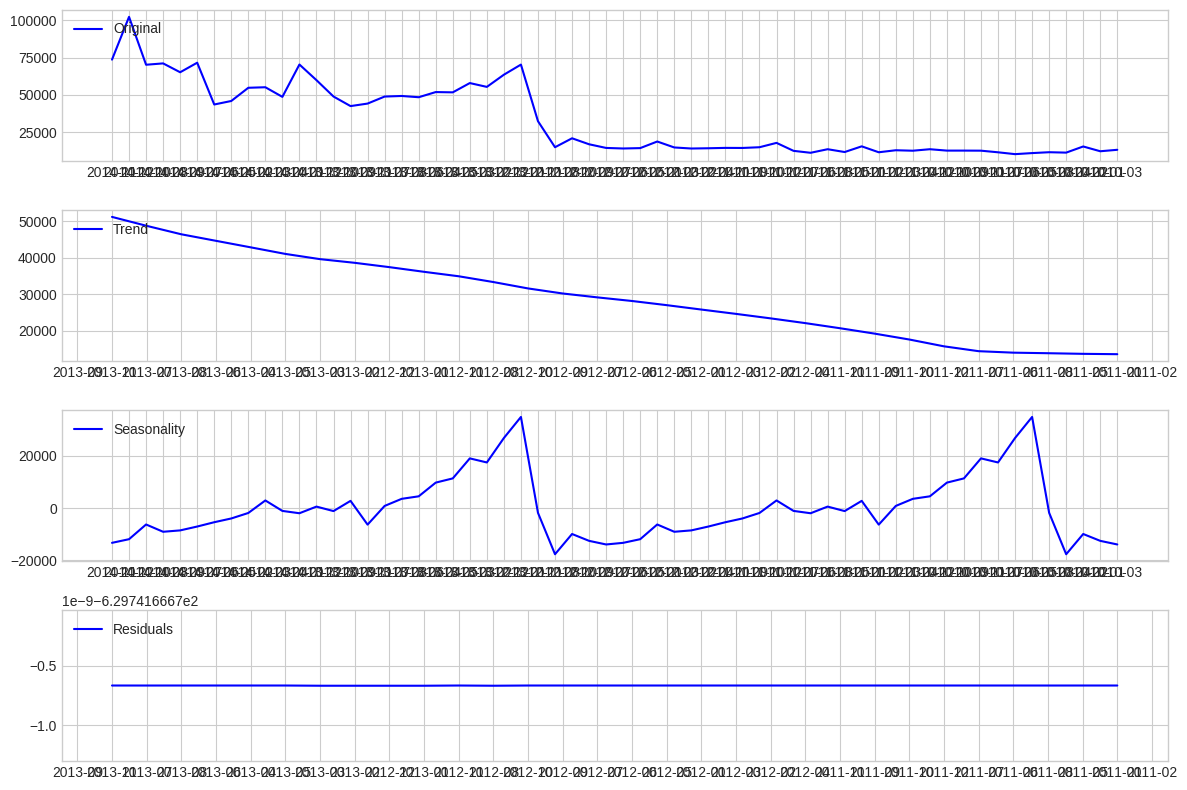

In [44]:
count_per_month2 = train_df.groupBy("review_date", "subcategory").agg(F.count("*").alias("count"))
df_pd2 = count_per_month2.toPandas()

df_pd2 = df_pd2[df_pd2['subcategory'] == 'Media']
df_pd2.set_index('review_date', inplace=True)
count_series = df_pd2['count']

result = seasonal_decompose(count_series, model='additive', period=30)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residuals', color='blue')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Data modeling
* Train your first model
## Tune ARIMA Model Parameters

In [45]:
##################### SET SUBCATEGORY ###########################
subcategory = 'Electronics'

/tmp/ipykernel_1245638/493278641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subcat['date'] = pd.to_datetime(df_subcat[['year', 'month']].assign(day = 1))
/tmp/ipykernel_1245638/493278641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subcat.sort_values(by = 'date', inplace = True)


<Figure size 1200x600 with 0 Axes>

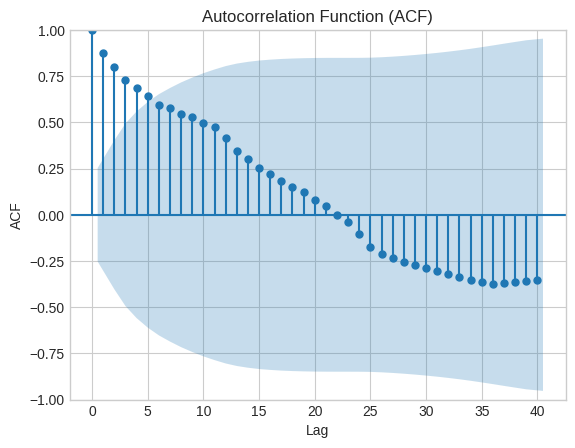

<Figure size 1200x600 with 0 Axes>

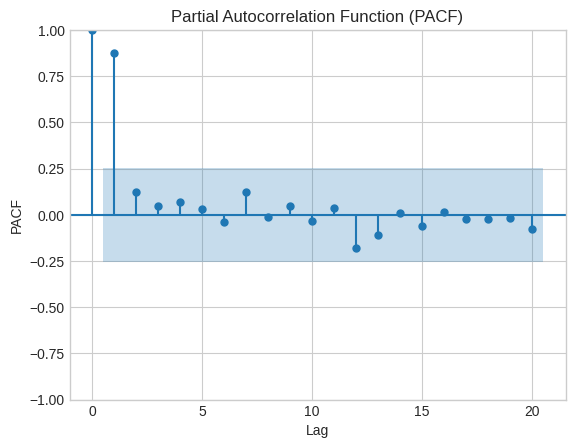

Forecast: 60    994812.531086
61    965466.031929
62    943676.540167
63    919487.591193
64    955603.341789
65    967721.095131
66    971786.909731
67    973151.093990
Name: predicted_mean, dtype: float64


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

In [46]:
df_subcat = df_pd[df_pd['subcategory'] == subcategory]
df_subcat['date'] = pd.to_datetime(df_subcat[['year', 'month']].assign(day = 1))
df_subcat.sort_values(by = 'date', inplace = True)
    
series = df_subcat.set_index('date')['count']
    
plt.figure(figsize = (12, 6))
plot_acf(series, lags = 40, alpha = 0.05)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()
    
# PACF plot
plt.figure(figsize = (12, 6))
plot_pacf(series, lags = 20, alpha = 0.05)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()
    
# Extract the time series data
series = df_subcat['count']
    
# Fit ARIMA model p,d,q
model = ARIMA(series, order=(1, 1, 5))  
model_fit = model.fit()
    
# 2015 Predictions 
forecast_steps = 8
forecast = model_fit.forecast(steps = forecast_steps) 
print("Forecast:", forecast)

## Time series model

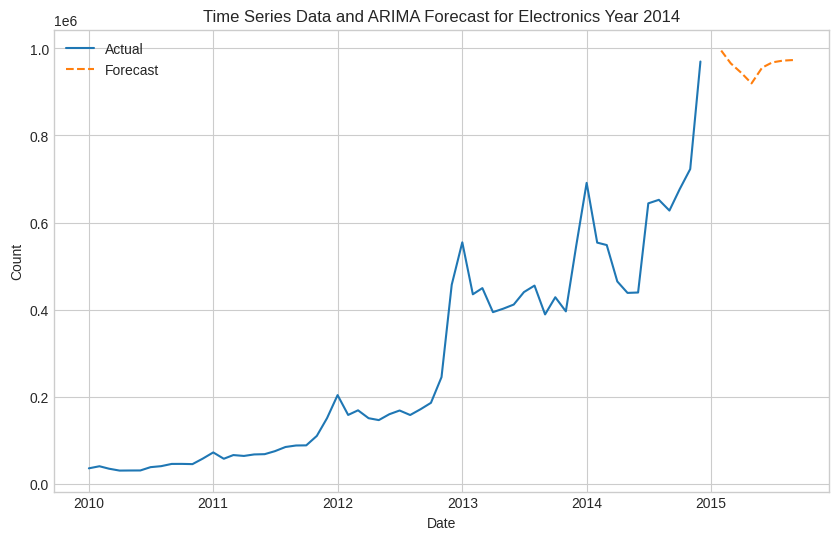

In [47]:
# time series data plot
plt.figure(figsize=(10, 6))
plt.plot(df_subcat['date'], df_subcat['count'], label='Actual')

# Plot the forecast
forecast_dates = pd.date_range(start=df_subcat['date'].iloc[-1], periods=forecast_steps + 1, freq='M')[1:]
plt.plot(forecast_dates, forecast, label='Forecast', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Data and ARIMA Forecast for %s Year 2014' % subcategory)
plt.legend()

plt.grid(True)
plt.show()

# Data Evaluation
* Evaluate your model and compare training vs. test error

In [55]:
from pyspark.sql.functions import col, date_format, year, month
test_df_filter = test.filter(col('product_category').isin('Video DVD', 'Music', 'Books', 'Video Games'))
test_df_filter= test_df_filter.select(col('review_date'), col('product_category'))
test_df_filter = test_df_filter.withColumn("review_date", date_format(col("review_date"), "yyyy-MM"))
test_df_filter = test_df_filter.withColumn("year", year("review_date"))
test_df_filter = test_df_filter.withColumn("month", month("review_date"))
#test_df_1 = test_df.filter((col('product_category') == 32))
test_df_filter.show(3)


+-----------+----------------+----+-----+
|review_date|product_category|year|month|
+-----------+----------------+----+-----+
|    2015-08|           Music|2015|    8|
|    2015-08|           Music|2015|    8|
|    2015-08|           Music|2015|    8|
+-----------+----------------+----+-----+
only showing top 3 rows



In [57]:
from pyspark.sql.functions import year, month, count as spark_count
# Group by 'year', 'month', and 'product_category_num' and count occurrences
test_count_per_month = test_df_filter.groupBy("year", "month").agg(spark_count("*").alias("count"))

test_count_per_month.show()

+----+-----+------+
|year|month| count|
+----+-----+------+
|2015|    8|195402|
|2015|    7|198553|
|2015|    6|194795|
|2015|    4|219000|
|2015|    3|265496|
|2015|    5|202111|
|2015|    2|263192|
|2015|    1|302662|
+----+-----+------+



In [58]:
test_count_per_month_pd = test_count_per_month.toPandas()
test_count_per_month_pd['date'] = pd.to_datetime(test_count_per_month_pd[['year', 'month']].assign(day=1))
test_count_per_month_pd.sort_values(by='date', inplace=True)

In [59]:
from math import sqrt
from sklearn.metrics import mean_squared_error

test_values = test_count_per_month.select('count').rdd.flatMap(lambda x: x).collect()
rmse = sqrt(mean_squared_error(test_values, forecast))
print('Test RMSE:', rmse)
# this is how off we predicted the actualy values. 

Test RMSE: 732528.8863402149


In [69]:
print(df_media.columns)

Index(['year', 'month', 'subcategory', 'count'], dtype='object')


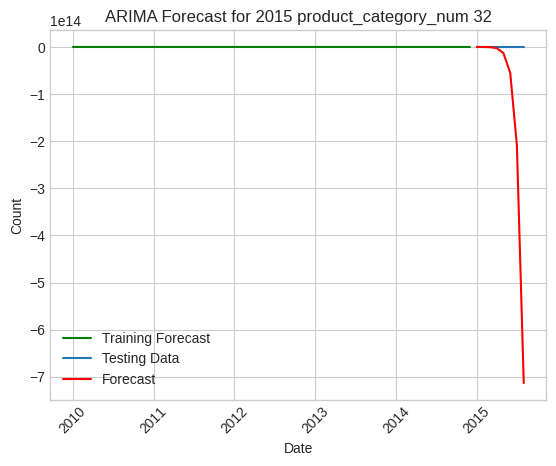

In [82]:
# Plot forecast, training, and testing data
df_media = df_pd[df_pd['subcategory'] == 'Media']

df_media['date'] = pd.to_datetime(df_media[['year', 'month']].assign(day=1))
df_media.sort_values(by='date', inplace=True)

plt.plot(df_media['date'], model_fit.fittedvalues, color='green', label='Training Forecast')


test_dates = pd.to_datetime(test_count_per_month_pd[['year', 'month']].assign(day=1))
plt.plot(test_dates, test_values, label='Testing Data')

# Plot forecast
plt.plot(test_dates, forecast, color='red', label='Forecast')

plt.title('ARIMA Forecast for 2015 product_category_num 32')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.legend()
plt.show()

### Fitting Graph

In [95]:
import warnings
warnings.filterwarnings("ignore")

count_per_month2 = count_per_month.filter((col('subcategory') == 'Media'))
train_values = count_per_month2.select('count').rdd.flatMap(lambda x: x).collect()

test_errors = []
train_errors = []
i_values = list(range(1,5))

for i in i_values:
    model = ARIMA(series, order=(5, 1+i, 5+i))
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=forecast_steps)
    train_rmse = sqrt(mean_squared_error(train_values, model_fit.fittedvalues))
    train_errors.append(train_rmse)
    
    test_rmse = sqrt(mean_squared_error(test_values, forecast))
    test_errors.append(test_rmse)

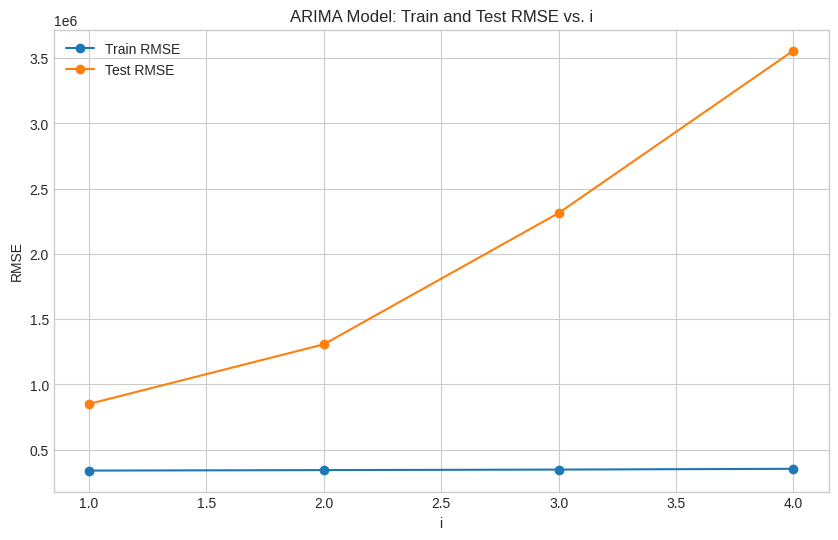

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(i_values, train_errors, label='Train RMSE', marker='o')
plt.plot(i_values, test_errors, label='Test RMSE', marker='o')
plt.xlabel('i')
plt.ylabel('RMSE')
plt.title('ARIMA Model: Train and Test RMSE vs. i')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
train_errors

[340002.1730687923, 343715.17575506016, 347676.90547365224, 353638.1987439632]

# Answer the questions
* Where does your model fit in the fitting graph? and What are the next models you are thinking of and why?

Based on the ARIMA model for product_category_num 32 of the year 2014, we forcasted the estimate of sales (with assumption based on reviews). The next models will include more training data, prior to 2014 for all product catgeories. We may possibily utilize the word2vector data to see the primary key words that have the highest count of reviews which we assume correlates to high counts of purchases. Through this we can forcast what speciifc item or product_category_num will increase in sales. However before moving on to more complicated models, our team will focus on building upon the ARIMA model to more acurately forcast which product_category_num is rise in sales/popular as the forcasted and test data concluded with a RMSE of 28498.15662477966. 

# Conclusion section
* What is the conclusion of your 1st model? What can be done to possibly improve it?

The 1st model concluded with an RMSE of 28498.156. This isn't the best given that there is almost a difference of 30k of the forcsted and the actualy 2015 test data for the product_category_num 32. We can increase the training data from 2014 to the range of 2010 to 2014. We do this for all the product_category_num to be able to accurately predict which item is more popular.  By increasing the training data we will be able to catch more underlying patterns thorughout the years. 